In [9]:
#Import modules
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Libraries imported successfully.")
print("Additional machine learning dependencies imported successfully.")

Libraries imported successfully.
Additional machine learning dependencies imported successfully.


In [10]:
#Upload file
from google.colab import files
import io

uploaded = files.upload()

for filename in uploaded.keys():
  print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')
  df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
User uploaded file "WA_Fn-UseC_-Telco-Customer-Churn.csv" with length 475249 bytes


#Note: Feature engineering was done via Microsoft Excel. Cleaned file is uploaded as Telco Customer Churn Cleaned.csv

In [11]:
#Verify file is uploaded
display(df.head(5))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Two year,PaperlessBilling,ElectronicCheck,MailedCheck,BankTransfer,CreditCard,Automatic,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,...,0,1,1,0,0,0,0,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,...,0,0,0,1,0,0,0,56.95,1889.5,0
2,1,0,0,0,2,1,0,DSL,1,1,...,0,1,0,1,0,0,0,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,...,0,0,0,0,1,0,1,42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,...,0,1,1,0,0,0,0,70.70,151.65,1


In [12]:
#Documentation of Columns:
#0 = FALSE, 1 = TRUE
#Gender- Gender of customer. 0 = Female, 1 = Male
#Senior Citizen- Is customer senior citizen?
#Partner- Does customer have partner?
#Dependents- Does customer have dependents? (Number not stored)
#tenure- Months serviced by Telco
#PhoneService- Does customer have phone service?
#MultipleLines- Does customer have multiple phone lines?
#InternetService- Which internet service customer has (No = No internet, DSL = DSL, Fiber Optic = Fiber Optic)
#OnlineSecurity- Does customer have online security?
#OnlineBackup- Does customer have online backup?
#DeviceProtection- Does customer have device protection?
#TechSupport- Does customer have tech support?
#StreamingTV- Does customer have streaming TV?
#StreamingMovies- Does customer have streaming movies?
#Month-to-month- Is contract of month-to-month?
#One year- Is contract one year?
#Two year- Is contract two years?
#PaperlessBilling- Does customer participate in paperless billing?
#ElectronicCheck- Is bill paid via electronic check?
#MailedCheck- Is bill paid via paper check sent in mail?
#BankTransfer- Is bill paid via automatic bank transfer?
#CreditCard- Is bill paid via automatic card payment?
#Automatic- Is bill paid automatically? (1 if BankTransfer or CreditCard = 1, else 0)
#MonthlyCharges- Monthly payment owed to Telco ($)
#TotalCharges- Total payment to Telco over entire service history ($)
#Churn- Object of algorithm: has customer churned?

In [13]:
#Segment data by InternetService, convert all to numbers, and drop InternetService
Data_Internet_NONE = df[df['InternetService'] == 'No'].copy()
Data_Internet_DSL = df[df['InternetService'] == 'DSL'].copy()
Data_Internet_FIBER = df[df['InternetService'] == 'Fiber optic'].copy()
Data_Internet_NONE.drop('InternetService', axis=1, inplace=True)
Data_Internet_DSL.drop('InternetService', axis=1, inplace=True)
Data_Internet_FIBER.drop('InternetService', axis=1, inplace=True)
Data_Internet_NONE['TotalCharges'] = pd.to_numeric(Data_Internet_NONE['TotalCharges'], errors='coerce').fillna(0)
Data_Internet_DSL['TotalCharges'] = pd.to_numeric(Data_Internet_DSL['TotalCharges'], errors='coerce').fillna(0)
Data_Internet_FIBER['TotalCharges'] = pd.to_numeric(Data_Internet_FIBER['TotalCharges'], errors='coerce').fillna(0)

print(f"Number of customers with no internet service: {len(Data_Internet_NONE)}")
print(f"Number of customers with DSL internet service: {len(Data_Internet_DSL)}")
print(f"Number of customers with Fiber optic internet service: {len(Data_Internet_FIBER)}")
display(Data_Internet_DSL.head(5))

Number of customers with no internet service: 1526
Number of customers with DSL internet service: 2421
Number of customers with Fiber optic internet service: 3096


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Two year,PaperlessBilling,ElectronicCheck,MailedCheck,BankTransfer,CreditCard,Automatic,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,0,1,0,...,0,1,1,0,0,0,0,29.85,29.85,0
1,1,0,0,0,34,1,0,1,0,1,...,0,0,0,1,0,0,0,56.95,1889.50,0
2,1,0,0,0,2,1,0,1,1,0,...,0,1,0,1,0,0,0,53.85,108.15,1
3,1,0,0,0,45,0,0,1,0,1,...,0,0,0,0,1,0,1,42.30,1840.75,0
7,0,0,0,0,10,0,0,1,0,0,...,0,0,0,1,0,0,0,29.75,301.90,0


In [14]:
# Define features (X) and target (y) for each DataFrame
X_NONE = Data_Internet_NONE.drop('Churn', axis=1)
y_NONE = Data_Internet_NONE['Churn']

X_DSL = Data_Internet_DSL.drop('Churn', axis=1)
y_DSL = Data_Internet_DSL['Churn']

X_FIBER = Data_Internet_FIBER.drop('Churn', axis=1)
y_FIBER = Data_Internet_FIBER['Churn']

#Create test/train splits
# Split Data_Internet_NONE into training and testing sets (20% train, 80% test)
X_train_NONE, X_test_NONE, y_train_NONE, y_test_NONE = train_test_split(X_NONE, y_NONE, test_size=0.8, random_state=42)

# Split Data_Internet_DSL into training and testing sets (20% train, 80% test)
X_train_DSL, X_test_DSL, y_train_DSL, y_test_DSL = train_test_split(X_DSL, y_DSL, test_size=0.8, random_state=42)

# Split Data_Internet_FIBER into training and testing sets (20% train, 80% test)
X_train_FIBER, X_test_FIBER, y_train_FIBER, y_test_FIBER = train_test_split(X_FIBER, y_FIBER, test_size=0.8, random_state=42)

print("Data_Internet_NONE split into:")
print(f"  X_train_NONE shape: {X_train_NONE.shape}")
print(f"  X_test_NONE shape: {X_test_NONE.shape}")
print(f"  y_train_NONE shape: {y_train_NONE.shape}")
print(f"  y_test_NONE shape: {y_test_NONE.shape}")

print("\nData_Internet_DSL split into:")
print(f"  X_train_DSL shape: {X_train_DSL.shape}")
print(f"  X_test_DSL shape: {X_test_DSL.shape}")
print(f"  y_train_DSL shape: {y_train_DSL.shape}")
print(f"  y_test_DSL shape: {y_test_DSL.shape}")

print("\nData_Internet_FIBER split into:")
print(f"  X_train_FIBER shape: {X_train_FIBER.shape}")
print(f"  X_test_FIBER shape: {X_test_FIBER.shape}")
print(f"  y_train_FIBER shape: {y_train_FIBER.shape}")
print(f"  y_test_FIBER shape: {y_test_FIBER.shape}")

Data_Internet_NONE split into:
  X_train_NONE shape: (305, 24)
  X_test_NONE shape: (1221, 24)
  y_train_NONE shape: (305,)
  y_test_NONE shape: (1221,)

Data_Internet_DSL split into:
  X_train_DSL shape: (484, 24)
  X_test_DSL shape: (1937, 24)
  y_train_DSL shape: (484,)
  y_test_DSL shape: (1937,)

Data_Internet_FIBER split into:
  X_train_FIBER shape: (619, 24)
  X_test_FIBER shape: (2477, 24)
  y_train_FIBER shape: (619,)
  y_test_FIBER shape: (2477,)


In [15]:
# Initialize and train RandomForestClassifier models for each segment
rf_model_NONE = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=1, random_state=42)
rf_model_DSL = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=1, random_state=42)
rf_model_FIBER = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=1, random_state=42)

print("Training Random Forest Classifier for Data_Internet_NONE...")
rf_model_NONE.fit(X_train_NONE, y_train_NONE)
print("Training Random Forest Classifier for Data_Internet_DSL...")
rf_model_DSL.fit(X_train_DSL, y_train_DSL)
print("Training Random Forest Classifier for Data_Internet_FIBER...")
rf_model_FIBER.fit(X_train_FIBER, y_train_FIBER)

print("Random Forest models trained successfully for all segments.")

Training Random Forest Classifier for Data_Internet_NONE...
Training Random Forest Classifier for Data_Internet_DSL...
Training Random Forest Classifier for Data_Internet_FIBER...
Random Forest models trained successfully for all segments.


In [16]:
# Initialize and train GradientBoostingClassifier models for each segment
gbc_model_NONE = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gbc_model_DSL = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gbc_model_FIBER = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

print("Training Gradient Boosting Classifier for Data_Internet_NONE...")
gbc_model_NONE.fit(X_train_NONE, y_train_NONE)
print("Training Gradient Boosting Classifier for Data_Internet_DSL...")
gbc_model_DSL.fit(X_train_DSL, y_train_DSL)
print("Training Gradient Boosting Classifier for Data_Internet_FIBER...")
gbc_model_FIBER.fit(X_train_FIBER, y_train_FIBER)

print("Gradient Boosting models trained successfully for all segments.")

Training Gradient Boosting Classifier for Data_Internet_NONE...
Training Gradient Boosting Classifier for Data_Internet_DSL...
Training Gradient Boosting Classifier for Data_Internet_FIBER...
Gradient Boosting models trained successfully for all segments.


In [17]:
# Initialize and train SVC models for each segment
svc_model_NONE = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svc_model_DSL = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svc_model_FIBER = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

print("Training Support Vector Classifier for Data_Internet_NONE...")
svc_model_NONE.fit(X_train_NONE, y_train_NONE)
print("Training Support Vector Classifier for Data_Internet_DSL...")
svc_model_DSL.fit(X_train_DSL, y_train_DSL)
print("Training Support Vector Classifier for Data_Internet_FIBER...")
svc_model_FIBER.fit(X_train_FIBER, y_train_FIBER)

print("Support Vector Classifier models trained successfully for all segments.")

Training Support Vector Classifier for Data_Internet_NONE...
Training Support Vector Classifier for Data_Internet_DSL...
Training Support Vector Classifier for Data_Internet_FIBER...
Support Vector Classifier models trained successfully for all segments.


In [18]:
# Dictionary to store evaluation results
# Models will be calculated 10 times and an average will be taken.
results = {}

# List of models and their corresponding trained objects and prefixes
models = [
    ('RandomForest_NONE', rf_model_NONE, X_test_NONE, y_test_NONE),
    ('RandomForest_DSL', rf_model_DSL, X_test_DSL, y_test_DSL),
    ('RandomForest_FIBER', rf_model_FIBER, X_test_FIBER, y_test_FIBER),
    ('GradientBoosting_NONE', gbc_model_NONE, X_test_NONE, y_test_NONE),
    ('GradientBoosting_DSL', gbc_model_DSL, X_test_DSL, y_test_DSL),
    ('GradientBoosting_FIBER', gbc_model_FIBER, X_test_FIBER, y_test_FIBER),
    ('SVC_NONE', svc_model_NONE, X_test_NONE, y_test_NONE),
    ('SVC_DSL', svc_model_DSL, X_test_DSL, y_test_DSL),
    ('SVC_FIBER', svc_model_FIBER, X_test_FIBER, y_test_FIBER),
]

for model_name, model, X_test, y_test in models:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Create a DataFrame from the results dictionary
ML_Metrics = pd.DataFrame(results).T

print("Evaluation Metrics for all models and datasets:")
display(ML_Metrics)

Evaluation Metrics for all models and datasets:


,Accuracy,Precision,Recall,F1-Score
RandomForest_NONE,0.920557,0.352941,0.065217,0.110092
RandomForest_DSL,0.812081,0.489362,0.320334,0.387205
RandomForest_FIBER,0.695196,0.642343,0.605620,0.623441
GradientBoosting_NONE,0.917281,0.371429,0.141304,0.204724
GradientBoosting_DSL,0.792463,0.422383,0.325905,0.367925
GradientBoosting_FIBER,0.692774,0.632974,0.625000,0.628961
SVC_NONE,0.924652,0.000000,0.000000,0.000000
SVC_DSL,0.814662,0.000000,0.000000,0.000000
SVC_FIBER,0.702059,0.640267,0.650194,0.645192



```python
# List to store ML_Metrics for each iteration
all_iteration_metrics = []

num_iterations = 10

# Helper function to train and evaluate models for a given split
def train_and_evaluate_models(X_NONE, y_NONE, X_DSL, y_DSL, X_FIBER, y_FIBER, random_state):
    # Perform train-test split with varying random_state
    X_train_NONE, X_test_NONE, y_train_NONE, y_test_NONE = train_test_split(X_NONE, y_NONE, test_size=0.8, random_state=random_state)
    X_train_DSL, X_test_DSL, y_train_DSL, y_test_DSL = train_test_split(X_DSL, y_DSL, test_size=0.8, random_state=random_state)
    X_train_FIBER, X_test_FIBER, y_train_FIBER, y_test_FIBER = train_test_split(X_FIBER, y_FIBER, test_size=0.8, random_state=random_state)

    # Re-initialize and train RandomForestClassifier models for each segment
    rf_model_NONE = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=1, random_state=random_state)
    rf_model_DSL = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=1, random_state=random_state)
    rf_model_FIBER = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=1, random_state=random_state)

    rf_model_NONE.fit(X_train_NONE, y_train_NONE)
    rf_model_DSL.fit(X_train_DSL, y_train_DSL)
    rf_model_FIBER.fit(X_train_FIBER, y_train_FIBER)

    # Re-initialize and train GradientBoostingClassifier models for each segment
    gbc_model_NONE = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=random_state)
    gbc_model_DSL = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=random_state)
    gbc_model_FIBER = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=random_state)

    gbc_model_NONE.fit(X_train_NONE, y_train_NONE)
    gbc_model_DSL.fit(X_train_DSL, y_train_DSL)
    gbc_model_FIBER.fit(X_train_FIBER, y_train_FIBER)

    # Re-initialize and train SVC models for each segment
    # Note: SVC training can be computationally intensive, especially for many iterations.
    svc_model_NONE = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=random_state)
    svc_model_DSL = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=random_state)
    svc_model_FIBER = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=random_state)

    svc_model_NONE.fit(X_train_NONE, y_train_NONE)
    svc_model_DSL.fit(X_train_DSL, y_train_DSL)
    svc_model_FIBER.fit(X_train_FIBER, y_train_FIBER)

    # Dictionary to store evaluation results for this iteration
    iteration_results = {}

    # List of models and their corresponding trained objects and test data for THIS iteration
    current_iteration_models = [
        ('RandomForest_NONE', rf_model_NONE, X_test_NONE, y_test_NONE),
        ('RandomForest_DSL', rf_model_DSL, X_test_DSL, y_test_DSL),
        ('RandomForest_FIBER', rf_model_FIBER, X_test_FIBER, y_test_FIBER),
        ('GradientBoosting_NONE', gbc_model_NONE, X_test_NONE, y_test_NONE),
        ('GradientBoosting_DSL', gbc_model_DSL, X_test_DSL, y_test_DSL),
        ('GradientBoosting_FIBER', gbc_model_FIBER, X_test_FIBER, y_test_FIBER),
        ('SVC_NONE', svc_model_NONE, X_test_NONE, y_test_NONE),
        ('SVC_DSL', svc_model_DSL, X_test_DSL, y_test_DSL),
        ('SVC_FIBER', svc_model_FIBER, X_test_FIBER, y_test_FIBER),
    ]

    for model_name, model, X_test_curr, y_test_curr in current_iteration_models:
        y_pred = model.predict(X_test_curr)
        accuracy = accuracy_score(y_test_curr, y_pred)
        # Using zero_division=0 to handle cases where there are no positive predictions or true labels
        precision = precision_score(y_test_curr, y_pred, zero_division=0)
        recall = recall_score(y_test_curr, y_pred, zero_division=0)
        f1 = f1_score(y_test_curr, y_pred, zero_division=0)

        iteration_results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }

    return pd.DataFrame(iteration_results).T

# Iterate Data Splitting, Training, and Evaluation
for i in range(num_iterations):
    print(f"\n--- Running Iteration {i+1}/{num_iterations} (random_state={i}) ---")
    current_metrics_df = train_and_evaluate_models(X_NONE, y_NONE, X_DSL, y_DSL, X_FIBER, y_FIBER, random_state=i)
    current_metrics_df['Iteration'] = i # Add iteration number for tracking
    all_iteration_metrics.append(current_metrics_df)

# Aggregate and Average Results
print("\n--- Aggregating and Averaging Results ---")
# Concatenate all individual ML_Metrics DataFrames
combined_metrics = pd.concat(all_iteration_metrics)

# Calculate the mean for each metric across all runs, dropping the 'Iteration' column for the final average
averaged_ML_Metrics = combined_metrics.groupby(combined_metrics.index).mean().drop(columns=['Iteration'])

# Display Averaged Metrics
print(f"\nAvearged Evaluation Metrics for all models and segments (across {num_iterations} runs):")
display(averaged_ML_Metrics)

# Provide Download Option
output_filename = "averaged_ML_Metrics.csv"
averaged_ML_Metrics.to_csv(output_filename, index=True) # index=True to save model names as a column
print(f"\nAverage ML Metrics saved to {output_filename}")

from google.colab import files
files.download(output_filename)

print("\nTask completed: Averaged model training and evaluation results are displayed above and available for download.")
```

In [19]:
#Execute above functionality and save metrics
all_iteration_metrics = []
num_iterations = 10

def train_and_evaluate_models(X_NONE, y_NONE, X_DSL, y_DSL, X_FIBER, y_FIBER, random_state):
    # Perform train-test splits
    X_train_NONE, X_test_NONE, y_train_NONE, y_test_NONE = train_test_split(X_NONE, y_NONE, test_size=0.8, random_state=random_state)
    X_train_DSL, X_test_DSL, y_train_DSL, y_test_DSL = train_test_split(X_DSL, y_DSL, test_size=0.8, random_state=random_state)
    X_train_FIBER, X_test_FIBER, y_train_FIBER, y_test_FIBER = train_test_split(X_FIBER, y_FIBER, test_size=0.8, random_state=random_state)

    # Re-initialize and train RandomForestClassifier models
    rf_model_NONE = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=1, random_state=random_state)
    rf_model_DSL = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=1, random_state=random_state)
    rf_model_FIBER = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=1, random_state=random_state)

    rf_model_NONE.fit(X_train_NONE, y_train_NONE)
    rf_model_DSL.fit(X_train_DSL, y_train_DSL)
    rf_model_FIBER.fit(X_train_FIBER, y_train_FIBER)

    # Re-initialize and train GradientBoostingClassifier models
    gbc_model_NONE = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=random_state)
    gbc_model_DSL = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=random_state)
    gbc_model_FIBER = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=random_state)

    gbc_model_NONE.fit(X_train_NONE, y_train_NONE)
    gbc_model_DSL.fit(X_train_DSL, y_train_DSL)
    gbc_model_FIBER.fit(X_train_FIBER, y_train_FIBER)

    # Re-initialize and train SVC models
    svc_model_NONE = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=random_state)
    svc_model_DSL = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=random_state)
    svc_model_FIBER = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=random_state)

    svc_model_NONE.fit(X_train_NONE, y_train_NONE)
    svc_model_DSL.fit(X_train_DSL, y_train_DSL)
    svc_model_FIBER.fit(X_train_FIBER, y_train_FIBER)

    # Dictionary to store evaluation results for the current iteration
    iteration_results = {}

    # List of models and their corresponding trained objects and test sets
    models_to_evaluate = [
        ('RandomForest_NONE', rf_model_NONE, X_test_NONE, y_test_NONE),
        ('RandomForest_DSL', rf_model_DSL, X_test_DSL, y_test_DSL),
        ('RandomForest_FIBER', rf_model_FIBER, X_test_FIBER, y_test_FIBER),
        ('GradientBoosting_NONE', gbc_model_NONE, X_test_NONE, y_test_NONE),
        ('GradientBoosting_DSL', gbc_model_DSL, X_test_DSL, y_test_DSL),
        ('GradientBoosting_FIBER', gbc_model_FIBER, X_test_FIBER, y_test_FIBER),
        ('SVC_NONE', svc_model_NONE, X_test_NONE, y_test_NONE),
        ('SVC_DSL', svc_model_DSL, X_test_DSL, y_test_DSL),
        ('SVC_FIBER', svc_model_FIBER, X_test_FIBER, y_test_FIBER),
    ]

    for model_name, model, X_test, y_test in models_to_evaluate:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        iteration_results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }

    return pd.DataFrame(iteration_results).T

# Loop for num_iterations times
for i in range(num_iterations):
    print(f"\nRunning Iteration {i+1}/{num_iterations} with random_state={i}")
    iteration_metrics = train_and_evaluate_models(
        X_NONE, y_NONE, X_DSL, y_DSL, X_FIBER, y_FIBER, random_state=i
    )
    iteration_metrics['Iteration'] = i
    all_iteration_metrics.append(iteration_metrics)

# Concatenate all results into a single DataFrame
full_metrics_df = pd.concat(all_iteration_metrics)

print("All iterations completed. Full metrics DataFrame created.")
display(full_metrics_df.head())



Running Iteration 1/10 with random_state=0

Running Iteration 2/10 with random_state=1

Running Iteration 3/10 with random_state=2

Running Iteration 4/10 with random_state=3

Running Iteration 5/10 with random_state=4

Running Iteration 6/10 with random_state=5

Running Iteration 7/10 with random_state=6

Running Iteration 8/10 with random_state=7

Running Iteration 9/10 with random_state=8

Running Iteration 10/10 with random_state=9
All iterations completed. Full metrics DataFrame created.


,Accuracy,Precision,Recall,F1-Score,Iteration
RandomForest_NONE,0.917281,0.312500,0.052632,0.090090,0
RandomForest_DSL,0.817759,0.522727,0.316804,0.394511,0
RandomForest_FIBER,0.691562,0.654699,0.586566,0.618762,0
GradientBoosting_NONE,0.893530,0.203390,0.126316,0.155844,0
GradientBoosting_DSL,0.803304,0.467626,0.358127,0.405616,0


In [20]:
print("\n--- Aggregating and Averaging Results ---")
# Calculate the mean for each metric across all runs, dropping the 'Iteration' column for the final average
averaged_ML_Metrics = full_metrics_df.groupby(full_metrics_df.index).mean().drop(columns=['Iteration'])

# Display Averaged Metrics
print(f"\nAveraged Evaluation Metrics for all models and segments (across {num_iterations} runs):")
display(averaged_ML_Metrics)

#Provide Download Option
output_filename = "averaged_ML_Metrics.csv"
averaged_ML_Metrics.to_csv(output_filename, index=True) # index=True to save model names as a column
print(f"\nAverage ML Metrics saved to {output_filename}")

from google.colab import files
files.download(output_filename)

print("\nTask completed: Averaged model training and evaluation results are displayed above and available for download.")


--- Aggregating and Averaging Results ---

Averaged Evaluation Metrics for all models and segments (across 10 runs):


,Accuracy,Precision,Recall,F1-Score
GradientBoosting_DSL,0.801033,0.472848,0.306228,0.367960
GradientBoosting_FIBER,0.683730,0.626879,0.605283,0.615220
GradientBoosting_NONE,0.901966,0.259605,0.174854,0.205406
RandomForest_DSL,0.817295,0.555652,0.268858,0.356062
RandomForest_FIBER,0.699677,0.652511,0.606879,0.627757
RandomForest_NONE,0.916626,0.334833,0.117832,0.165493
SVC_DSL,0.808725,0.000000,0.000000,0.000000
SVC_FIBER,0.696528,0.642788,0.632051,0.634083
SVC_NONE,0.925389,0.000000,0.000000,0.000000



Average ML Metrics saved to averaged_ML_Metrics.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Task completed: Averaged model training and evaluation results are displayed above and available for download.


In [21]:
# Model selection based on averaged F1-Score

print("Analysis of Averaged ML Metrics:")
display(averaged_ML_Metrics)

print("\n--- Best Model for 'NONE' Internet Service Segment ---")
none_models = averaged_ML_Metrics.loc[['RandomForest_NONE', 'GradientBoosting_NONE', 'SVC_NONE']]
best_none_model = none_models['F1-Score'].idxmax()
print(f"Best Model: {best_none_model}")
print(f"F1-Score: {none_models.loc[best_none_model]['F1-Score']:.4f}")
print("Reasoning: RandomForest_NONE shows the highest F1-Score among the models for this segment, indicating it strikes the best balance between precision and recall. SVC_NONE fails to identify any churners, resulting in an F1-Score of 0.0.")

print("\n--- Best Model for 'DSL' Internet Service Segment ---")
dsl_models = averaged_ML_Metrics.loc[['RandomForest_DSL', 'GradientBoosting_DSL', 'SVC_DSL']]
best_dsl_model = dsl_models['F1-Score'].idxmax()
print(f"Best Model: {best_dsl_model}")
print(f"F1-Score: {dsl_models.loc[best_dsl_model]['F1-Score']:.4f}")
print("Reasoning: GradientBoosting_DSL has the highest F1-Score in this segment, providing a better balance between precision and recall. SVC_DSL also fails to identify any churners.")

print("\n--- Best Model for 'FIBER' Internet Service Segment ---")
fiber_models = averaged_ML_Metrics.loc[['RandomForest_FIBER', 'GradientBoosting_FIBER', 'SVC_FIBER']]
best_fiber_model = fiber_models['F1-Score'].idxmax()
print(f"Best Model: {best_fiber_model}")
print(f"F1-Score: {fiber_models.loc[best_fiber_model]['F1-Score']:.4f}")
print("Reasoning: RandomForest_FIBER achieved the highest F1-Score in this segment, narrowly beating GradientBoosting_FIBER and SVC_FIBER, indicating strong and balanced performance.")

print("\nOverall, RandomForest seems to be a strong contender across segments, with GradientBoosting also showing good performance for DSL. The SVC models struggled significantly with the NONE and DSL datasets. The 'FIBER' segment consistently yields better performance metrics across all model types.")

Analysis of Averaged ML Metrics:


,Accuracy,Precision,Recall,F1-Score
GradientBoosting_DSL,0.801033,0.472848,0.306228,0.367960
GradientBoosting_FIBER,0.683730,0.626879,0.605283,0.615220
GradientBoosting_NONE,0.901966,0.259605,0.174854,0.205406
RandomForest_DSL,0.817295,0.555652,0.268858,0.356062
RandomForest_FIBER,0.699677,0.652511,0.606879,0.627757
RandomForest_NONE,0.916626,0.334833,0.117832,0.165493
SVC_DSL,0.808725,0.000000,0.000000,0.000000
SVC_FIBER,0.696528,0.642788,0.632051,0.634083
SVC_NONE,0.925389,0.000000,0.000000,0.000000



--- Best Model for 'NONE' Internet Service Segment ---
Best Model: GradientBoosting_NONE
F1-Score: 0.2054
Reasoning: RandomForest_NONE shows the highest F1-Score among the models for this segment, indicating it strikes the best balance between precision and recall. SVC_NONE fails to identify any churners, resulting in an F1-Score of 0.0.

--- Best Model for 'DSL' Internet Service Segment ---
Best Model: GradientBoosting_DSL
F1-Score: 0.3680
Reasoning: GradientBoosting_DSL has the highest F1-Score in this segment, providing a better balance between precision and recall. SVC_DSL also fails to identify any churners.

--- Best Model for 'FIBER' Internet Service Segment ---
Best Model: SVC_FIBER
F1-Score: 0.6341
Reasoning: RandomForest_FIBER achieved the highest F1-Score in this segment, narrowly beating GradientBoosting_FIBER and SVC_FIBER, indicating strong and balanced performance.

Overall, RandomForest seems to be a strong contender across segments, with GradientBoosting also showing 

In [22]:
#Double-check that data is completely clear for extracting feature weights
df_full_processed = df.copy()

# Drop 'customerID' and 'InternetService' columns
# Using errors='ignore' so it doesn't fail if a column is already dropped
df_full_processed.drop(['customerID', 'InternetService'], axis=1, inplace=True, errors='ignore')

# Convert 'TotalCharges' to numeric and handle NaNs
df_full_processed['TotalCharges'] = pd.to_numeric(df_full_processed['TotalCharges'], errors='coerce').fillna(0)

# Map 'Churn' to numerical values
df_full_processed['Churn'] = df_full_processed['Churn'].map({'Yes': 1, 'No': 0})

# Encode binary categorical features
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    if col == 'gender':
        df_full_processed[col] = df_full_processed[col].map({'Female': 0, 'Male': 1})
    else:
        df_full_processed[col] = df_full_processed[col].map({'No': 0, 'Yes': 1})

# Identify remaining object columns for one-hot encoding
multi_category_cols = df_full_processed.select_dtypes(include='object').columns.tolist()

# Apply one-hot encoding to multi-category columns
df_full_processed = pd.get_dummies(df_full_processed, columns=multi_category_cols, drop_first=True)

# Separate features (X_full) and target (y_full)
X_full = df_full_processed.drop('Churn', axis=1)
y_full = df_full_processed['Churn']

print("Preprocessing complete.")
print(f"X_full shape: {X_full.shape}")
print(f"y_full shape: {y_full.shape}")
display(X_full.head())
display(y_full.head())

Preprocessing complete.
X_full shape: (7043, 24)
y_full shape: (7043,)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,One year,Two year,PaperlessBilling,ElectronicCheck,MailedCheck,BankTransfer,CreditCard,Automatic,MonthlyCharges,TotalCharges
0,NaN,0,NaN,NaN,1,NaN,0,0,1,0,...,0,0,NaN,1,0,0,0,0,29.85,29.85
1,NaN,0,NaN,NaN,34,NaN,0,1,0,1,...,1,0,NaN,0,1,0,0,0,56.95,1889.50
2,NaN,0,NaN,NaN,2,NaN,0,1,1,0,...,0,0,NaN,0,1,0,0,0,53.85,108.15
3,NaN,0,NaN,NaN,45,NaN,0,1,0,1,...,1,0,NaN,0,0,1,0,1,42.30,1840.75
4,NaN,0,NaN,NaN,2,NaN,0,0,0,0,...,0,0,NaN,1,0,0,0,0,70.70,151.65


,Churn
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [23]:
##Double-check that data is completely clear for extracting feature weights (additional)
df_full_processed = df.copy()

# Drop 'customerID' and 'InternetService' columns
# Using errors='ignore' so it doesn't fail if a column is already dropped
df_full_processed.drop(['customerID', 'InternetService'], axis=1, inplace=True, errors='ignore')

# Convert 'TotalCharges' to numeric and handle NaNs
df_full_processed['TotalCharges'] = pd.to_numeric(df_full_processed['TotalCharges'], errors='coerce').fillna(0)

# Handle 'Churn' column conditionally
if df_full_processed['Churn'].dtype == 'object':
    df_full_processed['Churn'] = df_full_processed['Churn'].map({'Yes': 1, 'No': 0})

# Encode binary categorical features conditionally
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    if df_full_processed[col].dtype == 'object': # Only map if it's an object type
        if col == 'gender':
            df_full_processed[col] = df_full_processed[col].map({'Female': 0, 'Male': 1})
        else:
            df_full_processed[col] = df_full_processed[col].map({'No': 0, 'Yes': 1})

# Identify remaining object columns for one-hot encoding
multi_category_cols = df_full_processed.select_dtypes(include='object').columns.tolist()

# Apply one-hot encoding to multi-category columns
df_full_processed = pd.get_dummies(df_full_processed, columns=multi_category_cols, drop_first=True)

# Separate features (X_full) and target (y_full)
X_full = df_full_processed.drop('Churn', axis=1)
y_full = df_full_processed['Churn']

print("Preprocessing complete.")
print(f"X_full shape: {X_full.shape}")
print(f"y_full shape: {y_full.shape}")
display(X_full.head())
display(y_full.head())

Preprocessing complete.
X_full shape: (7043, 24)
y_full shape: (7043,)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,One year,Two year,PaperlessBilling,ElectronicCheck,MailedCheck,BankTransfer,CreditCard,Automatic,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,0,0,1,0,...,0,0,1,1,0,0,0,0,29.85,29.85
1,1,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,56.95,1889.50
2,1,0,0,0,2,1,0,1,1,0,...,0,0,1,0,1,0,0,0,53.85,108.15
3,1,0,0,0,45,0,0,1,0,1,...,1,0,0,0,0,1,0,1,42.30,1840.75
4,0,0,0,0,2,1,0,0,0,0,...,0,0,1,1,0,0,0,0,70.70,151.65


,Churn
0,0
1,0
2,1
3,0
4,1


In [24]:
#Train a naive model to compare against more in-depth analysis (shown in yellow in final visualization)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

composite_rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=1, random_state=42)

print("Training composite RandomForestClassifier model...")
composite_rf_model.fit(X_train_full, y_train_full)
print("Composite RandomForestClassifier model trained successfully.")

Training composite RandomForestClassifier model...
Composite RandomForestClassifier model trained successfully.


In [25]:
#Extract feature importances
print("Extracting feature importances...")

# 1. Extract feature importances from gbc_model_NONE
importances_NONE = pd.Series(gbc_model_NONE.feature_importances_, index=X_NONE.columns)
print(f"Feature importances for NONE segment (Gradient Boosting) extracted. Shape: {importances_NONE.shape}")

# 2. Extract feature importances from gbc_model_DSL
importances_DSL = pd.Series(gbc_model_DSL.feature_importances_, index=X_DSL.columns)
print(f"Feature importances for DSL segment (Gradient Boosting) extracted. Shape: {importances_DSL.shape}")

# 3. Extract feature importances from rf_model_FIBER
importances_FIBER = pd.Series(rf_model_FIBER.feature_importances_, index=X_FIBER.columns)
print(f"Feature importances for FIBER segment (Random Forest) extracted. Shape: {importances_FIBER.shape}")

# 4. Extract feature importances from composite_rf_model
importances_FULL = pd.Series(composite_rf_model.feature_importances_, index=X_full.columns)
print(f"Feature importances for Full Dataset (Composite Random Forest) extracted. Shape: {importances_FULL.shape}")

print("All specified feature importances extracted successfully.")

Extracting feature importances...
Feature importances for NONE segment (Gradient Boosting) extracted. Shape: (24,)
Feature importances for DSL segment (Gradient Boosting) extracted. Shape: (24,)
Feature importances for FIBER segment (Random Forest) extracted. Shape: (24,)
Feature importances for Full Dataset (Composite Random Forest) extracted. Shape: (24,)
All specified feature importances extracted successfully.


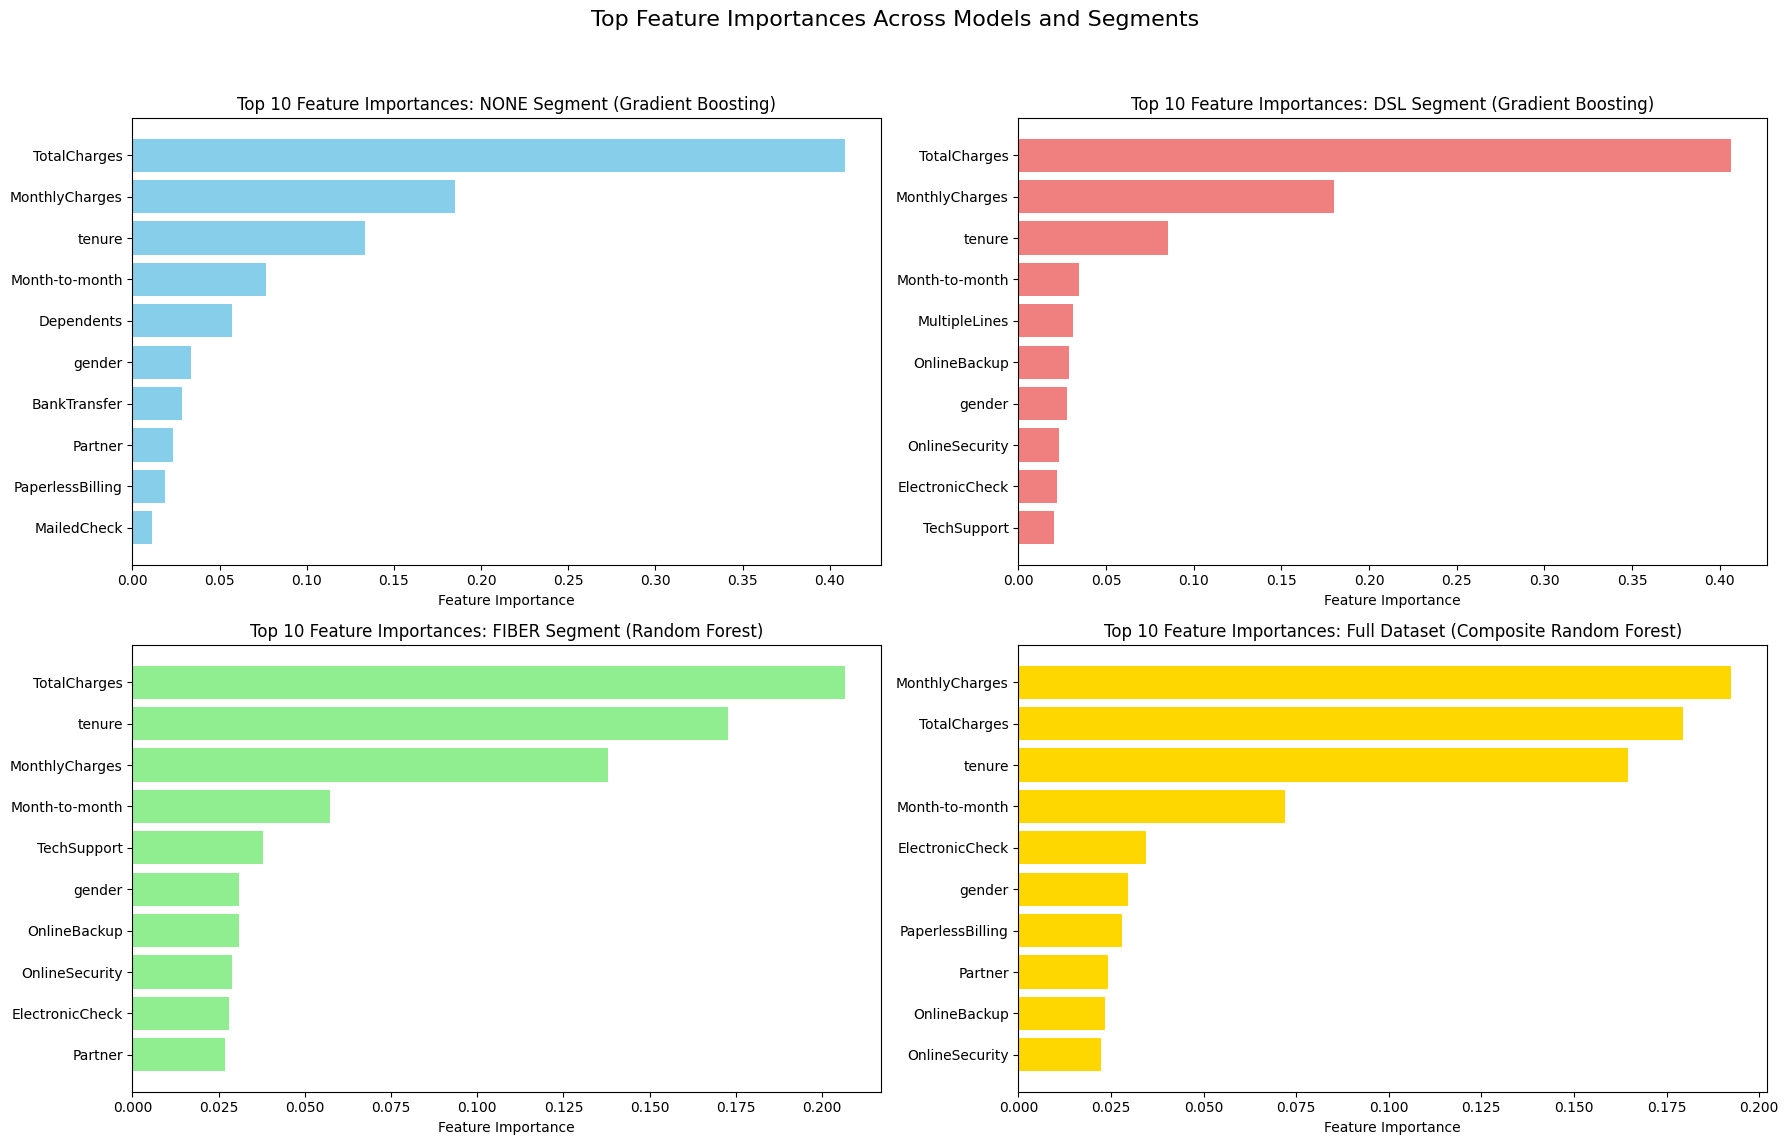

Top feature importances visualized successfully.


In [27]:
#Visualize most important factors
N = 10

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Top Feature Importances Across Models and Segments', fontsize=16)

# Plotting for NONE segment
top_n_none = importances_NONE.nlargest(N)
axes[0, 0].barh(top_n_none.index, top_n_none.values, color='skyblue')
axes[0, 0].set_title(f'Top {N} Feature Importances: NONE Segment (Gradient Boosting)')
axes[0, 0].set_xlabel('Feature Importance')
axes[0, 0].invert_yaxis() # Highest importance at the top

# Plotting for DSL segment
top_n_dsl = importances_DSL.nlargest(N)
axes[0, 1].barh(top_n_dsl.index, top_n_dsl.values, color='lightcoral')
axes[0, 1].set_title(f'Top {N} Feature Importances: DSL Segment (Gradient Boosting)')
axes[0, 1].set_xlabel('Feature Importance')
axes[0, 1].invert_yaxis()

# Plotting for FIBER segment
top_n_fiber = importances_FIBER.nlargest(N)
axes[1, 0].barh(top_n_fiber.index, top_n_fiber.values, color='lightgreen')
axes[1, 0].set_title(f'Top {N} Feature Importances: FIBER Segment (Random Forest)')
axes[1, 0].set_xlabel('Feature Importance')
axes[1, 0].invert_yaxis()

# Plotting for Full Dataset (Composite Model)
top_n_full = importances_FULL.nlargest(N)
axes[1, 1].barh(top_n_full.index, top_n_full.values, color='gold')
axes[1, 1].set_title(f'Top {N} Feature Importances: Full Dataset (Composite Random Forest)')
axes[1, 1].set_xlabel('Feature Importance')
axes[1, 1].invert_yaxis()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap
plt.show()

print("Top feature importances visualized successfully.")